## Zeitreihenannanalyse 

	1.	Datenvorbereitung und -sichtung
	2.	Stationaritätsprüfung (ADF-Test)
	3.	Analyse der Autokorrelation (ACF) und partiellen Autokorrelation (PACF)
	4.	ARIMA-Modellierung (Ermittlung und Interpretation der Koeffizienten)
	5.	Vorhersage auf Testdaten samt Gütemaßen
	6.	Zukunftsprognose

In [2]:
pip install -r requirements.txt --break-system-packages


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


            Preis
Datum            
2000-01-04  25.55
2000-01-05  24.91
2000-01-06  24.78
2000-01-07  24.22
2000-01-10  24.67
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5622 entries, 2000-01-04 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Preis   5622 non-null   float64
dtypes: float64(1)
memory usage: 87.8 KB
None


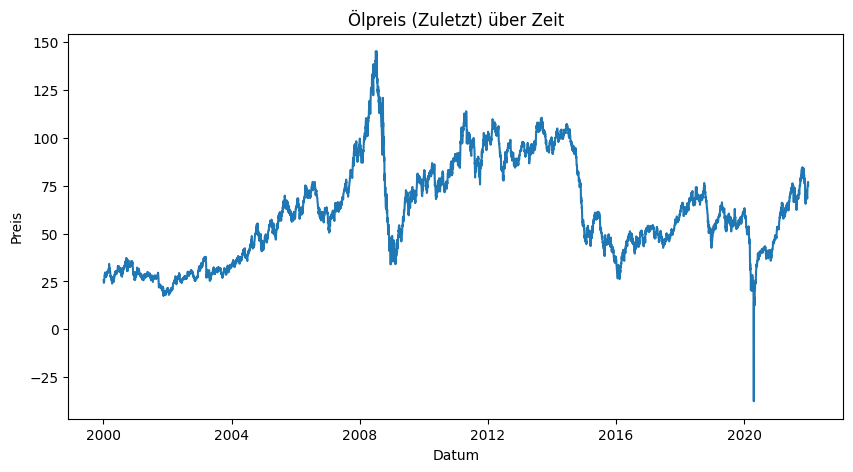

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Daten laden
df = pd.read_excel('/Users/danielambach/Projects/data_mining_dsba/data/raw/Ölpreis.xlsx')

# Nur relevante Spalten auswählen: "Datum", "Zuletzt"
df = df[['Datum', 'Zuletzt']].copy()
df.columns = ['Datum', 'Preis']

# Datumsformat umwandeln und Index setzen
df['Datum'] = pd.to_datetime(df['Datum'])
df = df.set_index('Datum').sort_index()

# Schneller Blick auf die Daten
print(df.head())
print(df.info())

# Zeitreihen-Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Preis'])
plt.title('Ölpreis (Zuletzt) über Zeit')
plt.xlabel('Datum')
plt.ylabel('Preis')
plt.show()

Interpretation:

	•	Der ADF-Test zeigt (siehe unten), dass die Originalreihe nicht stationär ist (p-Wert > 0,05).
	•	Der Preis schwankt über die Jahre und hat keinen offensichtlichen konstanten Mittelwert.

### 2. Stationaritätsprüfung (ADF-Test)

Zur Überprüfung, ob eine Zeitreihe stationär ist, kann man den Augmented Dickey-Fuller (ADF)-Test verwenden:

In [2]:
# ADF-Test auf Originalreihe
result_adf = adfuller(df['Preis'], autolag='AIC')
print("ADF-Test auf Originaldaten:")
print(f"ADF-Statistik: {result_adf[0]:.4f}")
print(f"p-Wert       : {result_adf[1]:.4f}")
for key, value in result_adf[4].items():
    print(f"  Kritischer Wert {key}: {value:.4f}")

# Differenzieren (1. Differenz)
df_diff = df['Preis'].diff().dropna()

# ADF-Test auf differenzierten Daten
result_adf_diff = adfuller(df_diff, autolag='AIC')
print("\nADF-Test auf 1. Differenz:")
print(f"ADF-Statistik: {result_adf_diff[0]:.4f}")
print(f"p-Wert       : {result_adf_diff[1]:.4f}")
for key, value in result_adf_diff[4].items():
    print(f"  Kritischer Wert {key}: {value:.4f}")

ADF-Test auf Originaldaten:
ADF-Statistik: -2.2108
p-Wert       : 0.2024
  Kritischer Wert 1%: -3.4315
  Kritischer Wert 5%: -2.8621
  Kritischer Wert 10%: -2.5670

ADF-Test auf 1. Differenz:
ADF-Statistik: -60.7389
p-Wert       : 0.0000
  Kritischer Wert 1%: -3.4315
  Kritischer Wert 5%: -2.8621
  Kritischer Wert 10%: -2.5670


Interpretation:

	•	Bei vielen Finanzzeitreihen ist die Datenreihe (z. B. Preise) typischerweise nicht stationär.
	•	Nach der ersten Differenzierung weist die Reihe meist Stationarität auf (p-Wert < 0,05).

## 3. Autokorrelation (ACF) und partielle Autokorrelation (PACF)

Mit ACF und PACF untersucht man, welche Verzögerungen (Lags) in der Zeitreihe noch Einfluss haben. Bei einer stationären Zeitreihe (hier: der differenzierten) sieht man das Abklingen der Autokorrelation:

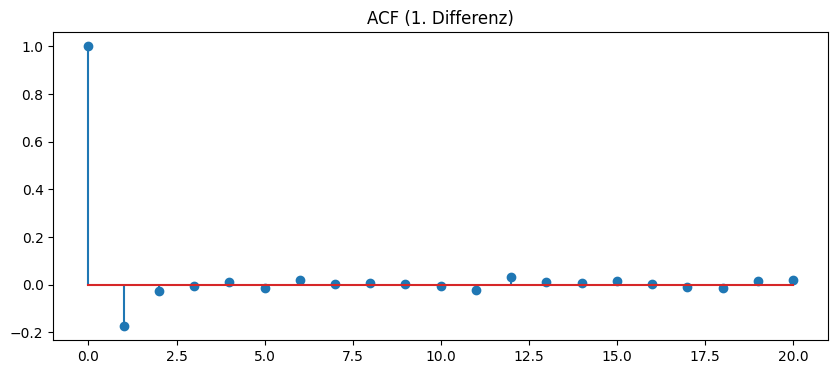

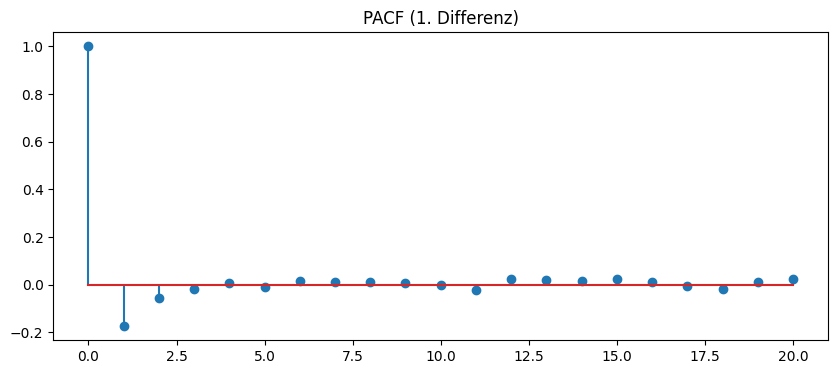

In [3]:
from statsmodels.tsa.stattools import acf, pacf

# ACF und PACF auf differenzierten Daten
lag_acf = acf(df_diff, nlags=20)
lag_pacf = pacf(df_diff, nlags=20, method='ols')

plt.figure(figsize=(10,4))
plt.stem(range(len(lag_acf)), lag_acf)
plt.title('ACF (1. Differenz)')
plt.show()

plt.figure(figsize=(10,4))
plt.stem(range(len(lag_pacf)), lag_pacf)
plt.title('PACF (1. Differenz)')
plt.show()

Interpretation:

	•	Die ACF zeigt, wie stark die Zeitreihe mit ihren vergangenen Werten korreliert.
	•	Die PACF hilft, den zusätzlichen Erklärungsbeitrag eines bestimmten Lags zu identifizieren, wenn kürzere Lags bereits im Modell sind.

## 4. ARIMA-Modellierung

Basierend auf ACF/PACF und Modellwahl (z. B. durch Informationskriterien AIC/BIC) wählt man die Parameter  p, d, q  für ein ARIMA(p,d,q). In diesem Beispiel verwenden wir als Demonstration ein ARIMA(1,1,1).

In [4]:
import statsmodels.api as sm

# Split in Trainings- und Testdaten (80% / 20%)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]['Preis']
test_data = df.iloc[train_size:]['Preis']

# ARIMA(1,1,1) definieren
model = sm.tsa.ARIMA(train_data, order=(1,1,1))
results = model.fit()

# Modell-Zusammenfassung
print(results.summary())

# Koeffizienten (ar.L1, ma.L1, sigma2) anzeigen
print("\nKoeffizienten:")
print(results.params)

                               SARIMAX Results                                
Dep. Variable:                  Preis   No. Observations:                 4497
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7974.452
Date:                Wed, 05 Mar 2025   AIC                          15954.904
Time:                        08:06:55   BIC                          15974.137
Sample:                             0   HQIC                         15961.681
                               - 4497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2609      0.180      1.451      0.147      -0.091       0.613
ma.L1         -0.3112      0.176     -1.763      0.078      -0.657       0.035
sigma2         2.0328      0.018    114.664      0.0

/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Interpretation der Modellkoeffizienten

	•	ar.L1: Einfluss des vorherigen Wertes (AR-Teil) auf die aktuelle (differenzierte) Größe. Ist dieser positiv und signifikant, deutet es auf eine gewisse Trägheit (Persistenz) hin.
	•	ma.L1: Einfluss eines Fehlerterms aus der Vergangenheit (MA-Teil). Ein negativer und signifikanter Wert kann heißen, dass starke zufällige Abweichungen in einer Periode Tendenz haben, sich in der nächsten Periode auszugleichen.
	•	sigma2: Varianz des Fehlerterms (Rauschkomponente).

Die p-Werte im Modellsummary (im ARIMA-Output unter „P>|z|“) zeigen an, ob die jeweiligen Koeffizienten statistisch signifikant (z. B. < 0,05) sind.

## 5. Vorhersage und Güte auf Testdaten

Wir lassen das Modell auf Basis der Trainingsdaten Vorhersagen für den Zeitraum der Testdaten erstellen und vergleichen sie mit den tatsächlichen Werten. Zur Bewertung nehmen wir beispielsweise RMSE und MAE:

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Vorhersagen im Testzeitraum
start_idx = train_size
end_idx = len(df) - 1

predictions = results.predict(start=start_idx, end=end_idx, typ='levels')

rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")


RMSE: 14.7456
MAE : 12.2167


/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [21]:
df.head()

,Preis
Datum,
2000-01-04,25.55
2000-01-05,24.91
2000-01-06,24.78
2000-01-07,24.22
2000-01-10,24.67


Interpretation der Gütemaße:

	•	RMSE (Root Mean Squared Error): Quadratwurzel des durchschnittlichen quadratischen Fehlers.
	•	MAE (Mean Absolute Error): durchschnittlicher absoluter Fehler.

Je kleiner die Werte, desto besser das Modell. Was „klein“ ist, hängt vom Maßstab des Ölpreises ab.

/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Test-RMSE: 14.73
Test-MAE : 12.20


/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


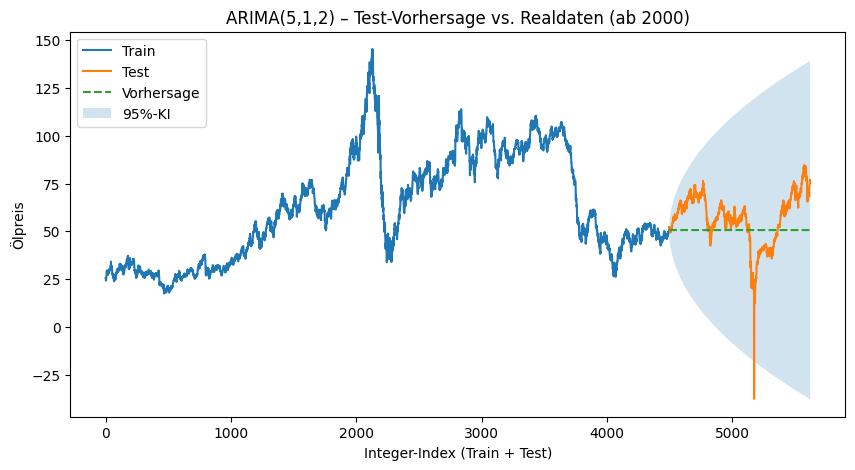

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Daten laden und nur ab Jahr 2000
df = pd.read_excel("/Users/danielambach/Projects/data_mining_dsba/data/raw/Ölpreis.xlsx")
df = df[['Datum', 'Zuletzt']].copy()
df.columns = ['Datum', 'Preis']
df['Datum'] = pd.to_datetime(df['Datum'])
df = df[df['Datum'] >= '2000-01-01'].copy()
df.sort_values('Datum', inplace=True)

# 2) Train-/Test-Split (80% / 20%)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]['Preis']
test_data  = df.iloc[train_size:]['Preis']

# 3) ARIMA-Modell schätzen
model = sm.tsa.ARIMA(train_data, order=(10,1,2))
results = model.fit()

# 4) Prognose auf Testdatensatz (Integer-Indizes!)
start_idx = train_size
end_idx   = len(df) - 1
prediction = results.get_prediction(start=start_idx, end=end_idx, dynamic=False)

pred_mean = prediction.predicted_mean
pred_conf = prediction.conf_int(alpha=0.05)  # 95%-Konfidenzintervall

# 5) Gütemaße
rmse = np.sqrt(mean_squared_error(test_data, pred_mean))
mae  = mean_absolute_error(test_data, pred_mean)
print(f"Test-RMSE: {rmse:.2f}")
print(f"Test-MAE : {mae:.2f}")

# 6) Plot (Integer-Indizes auf der x-Achse)
plt.figure(figsize=(10,5))

# a) Trainingswerte
plt.plot(range(train_size), train_data, label='Train')

# b) Reale Testwerte
plt.plot(range(train_size, len(df)), test_data, label='Test')

# c) Prognose (gestrichelte Linie)
plt.plot(range(train_size, len(df)), pred_mean, '--', label='Vorhersage')

# d) Konfidenzintervalle
plt.fill_between(
    range(train_size, len(df)),
    pred_conf.iloc[:, 0],
    pred_conf.iloc[:, 1],
    alpha=0.2,
    label='95%-KI'
)

plt.title('ARIMA(5,1,2) – Test-Vorhersage vs. Realdaten (ab 2000)')
plt.xlabel('Integer-Index (Train + Test)')
plt.ylabel('Ölpreis')
plt.legend()
plt.show()


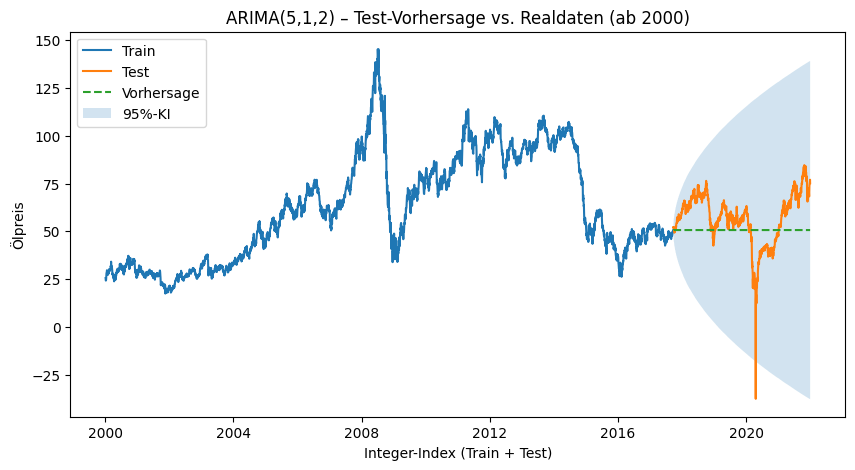

In [18]:


# 6) Plot (Integer-Indizes auf der x-Achse)
plt.figure(figsize=(10,5))


# a) Trainingswerte
plt.plot(df.index[range(train_size)], train_data, label='Train')

# b) Reale Testwerte
plt.plot(df.index[range(train_size, len(df))], test_data, label='Test')

# c) Prognose (gestrichelte Linie)
plt.plot(df.index[range(train_size, len(df))], pred_mean, '--', label='Vorhersage')

# d) Konfidenzintervalle
plt.fill_between(
    df.index[range(train_size, len(df))],
    pred_conf.iloc[:, 0],
    pred_conf.iloc[:, 1],
    alpha=0.2,
    label='95%-KI'
)

plt.title('ARIMA(5,1,2) – Test-Vorhersage vs. Realdaten (ab 2000)')
plt.xlabel('Integer-Index (Train + Test)')
plt.ylabel('Ölpreis')
plt.legend()
plt.show()